In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from features.extractor import FeatureExtractor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from scipy.stats.mstats import winsorize

/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [2]:
customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')

In [3]:
fe = FeatureExtractor(sales=sales, customers=customers, target_month=3, perform_split=False)
X, y = fe.transform()
# X['monetary'] = X[['qty_1-7', 'qty_8-14', 'qty_15-21', 'qty_22-28']].sum(axis=1)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
Successfully logged out.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


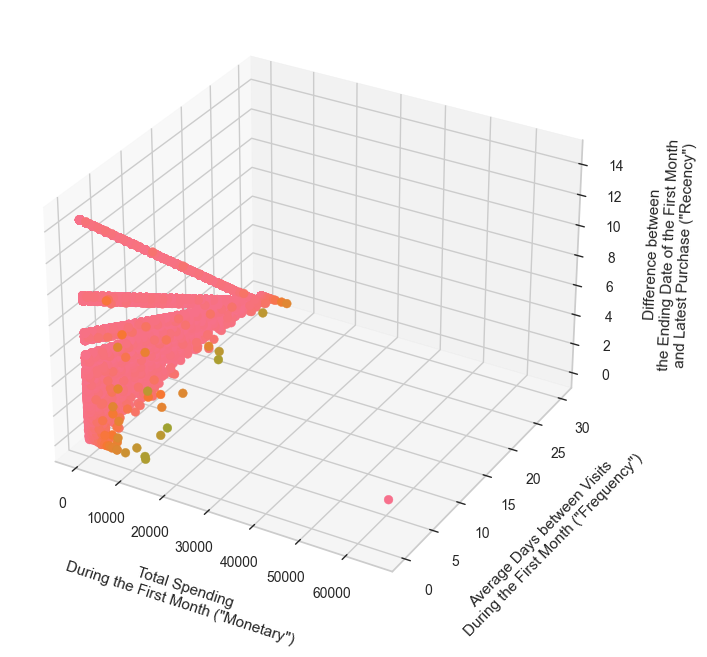

In [4]:
# X_clust = X[X['monetary']<=1000][['monetary', 'recency', 'average_days_between_visits']]

X_clust = X[['monetary', 'recency', 'average_days_between_visits']]

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

sc = ax.scatter(X_clust['monetary'], X_clust['recency'], X_clust['average_days_between_visits'], s=40, c=X_clust['monetary'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Total Spending\nDuring the First Month ("Monetary")', labelpad=20)
ax.set_ylabel('Average Days between Visits\nDuring the First Month ("Frequency")', labelpad=20)
ax.set_zlabel('Difference between\nthe Ending Date of the First Month\nand Latest Purchase ("Recency")', labelpad=20)

ax.legend()
fig.show()

Plot shows extreme outliers for the Monetary variable. Let us examine 99th percentile of this variable

In [5]:
print(f"99th percentile: {X_clust['monetary'].quantile(0.99)}")
print(f"Maximum: {X_clust['monetary'].max()}")

99th percentile: 1000.0
Maximum: 65200.0


Since the 99th percentile differs from the maximum value, it makes sense to winsorize these outliers

In [6]:
winsor = winsorize(X['monetary'], limits=(0.0, 0.01))
with open('./features/winsorizing_object_for_threshold.pkl', 'wb') as f:
    pickle.dump(winsor, f)
X_clust['monetary'] = winsor
X_clust['monetary'].max()

1000.0

Let us now examine the plot again

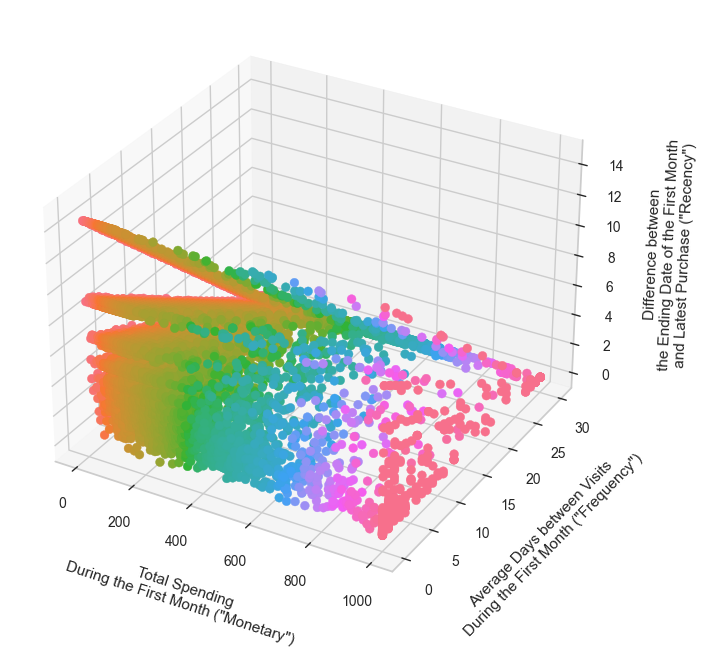

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

sc = ax.scatter(X_clust['monetary'], X_clust['recency'], X_clust['average_days_between_visits'], s=40, c=X_clust['monetary'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Total Spending\nDuring the First Month ("Monetary")', labelpad=20)
ax.set_ylabel('Average Days between Visits\nDuring the First Month ("Frequency")', labelpad=20)
ax.set_zlabel('Difference between\nthe Ending Date of the First Month\nand Latest Purchase ("Recency")', labelpad=20)

fig.show()

Examining the plot, one may consider that 3 or 4 clusters could be optimal

In [8]:
X_clust = StandardScaler().fit_transform(X_clust)
model = KMeans()
elbow_viz = KElbowVisualizer(model, k=(1, 11))

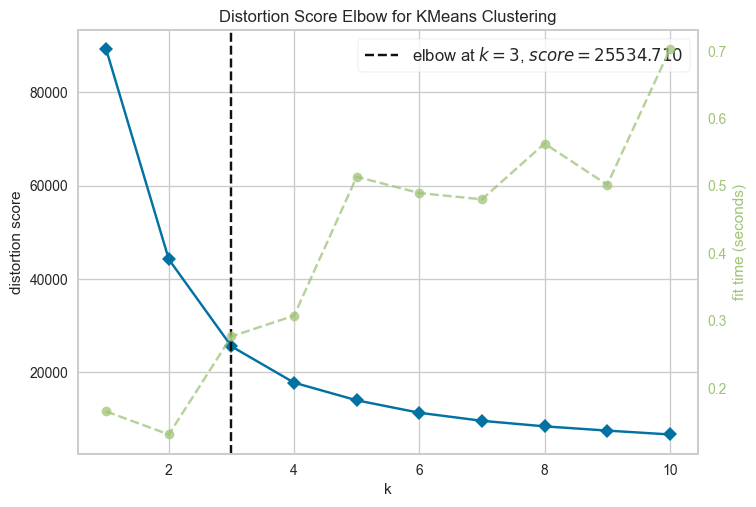

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
elbow_viz.fit(X_clust)
elbow_viz.show()

Elbow method suggests 3 clusters as the optimal value. Let us also compute silhoutte ccore:

In [10]:
for k in range(2, 11):
    model = KMeans(k)
    labels = model.fit_predict(X_clust)
    print(f'{k}: {silhouette_score(X_clust, labels)}')

2: 0.5509308869853029
3: 0.5993352557424202
4: 0.5240105830398467
5: 0.5253588411941126
6: 0.5310005699016053
7: 0.5096716689830445
8: 0.5244513080649249
9: 0.5132510967636619
10: 0.5170659785744689


The best silhoutte score was also computed for 3 clusters

In [11]:
K = 3
best_model = KMeans(n_clusters=K, random_state=571)
labels = best_model.fit_predict(X_clust)
centroids = best_model.cluster_centers_

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

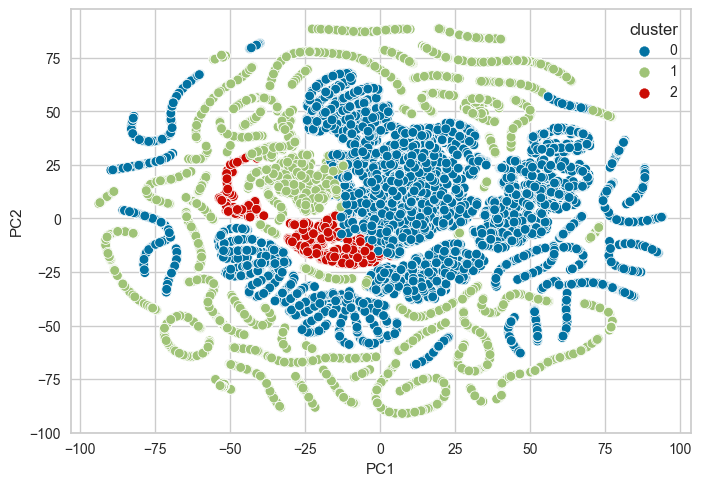

In [12]:
fig, ax = plt.subplots()

tsne = TSNE(n_components=2, random_state=0)
df_clust = pd.DataFrame(tsne.fit_transform(X_clust), columns=['PC1','PC2'])
df_clust['cluster'] = pd.Categorical(labels)

sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_clust, ax=ax)

In [13]:
X['cluster'] = pd.Categorical(labels)
X['cluster'].value_counts().sort_index()

0    15947
1    12340
2     1443
Name: cluster, dtype: int64

In [14]:
X[['cluster', 'monetary', 'recency', 'average_days_between_visits']].groupby('cluster').median().rename({'average_days_between_visits': 'frequency'}, axis=1)

,monetary,recency,frequency
cluster,,,
0,100.180,5.0,5.666667
1,34.715,30.0,0.000000
2,600.000,4.0,1.600000


- Cluster 0:
    - medium spending
    - medium recency
    - medium frequency

This cluster customers are quite loyal but, perhaps, not driving this much, so they do not need to visit gas stations often and pay much

- Cluster 1:
    - lowest spending
    - worst recency
    - fewest frequency

This cluster represents users who made one-two visits and most likely left

- Cluster 2:
    - highest spending
    - best recency
    - best frequency

This cluster represents user who are frequently visiting gas stations, paying a lot. Perhaps, these are the most loyal customers who are driving long distances

In [15]:
X['target'] = y

In [16]:
(X.groupby('target')['cluster'].value_counts(normalize=True).sort_index().apply(lambda x: f'{np.round(x*100, 2)}%')).to_frame()

cluster
target          
0      0  37.62%
       1  58.74%
       2   3.63%
1      0  70.75%
       1   23.1%
       2   6.16%

Customers who did not make a transaction during the third month mostly represented by Cluster 1 with the least loyal customers. Therefore, clusters, retrieved from the model could be a useful feature

In [17]:
import pickle
with open('./features/clustering_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [18]:
pd.Series(best_model.labels_).value_counts()

0    15947
1    12340
2     1443
dtype: int64

In [19]:
with open('./features/clustering_model.pkl', 'rb') as f:
            model = pickle.load(f)
        # Load `scipy.stats.mstats.winsorize` output object to define threshold for the `monetary` variable
with open('./features/winsorizing_object_for_threshold.pkl', 'rb') as f:
    winsor = pickle.load(f)
X_clust = X[['monetary', 'recency', 'average_days_between_visits']]
monetary_threshold = winsor.max()
# Perform winsorization
X_clust.loc[X_clust['monetary'] > monetary_threshold, 'monetary'] = monetary_threshold
scaler = StandardScaler()
labels = pd.Categorical(
    model.predict(
        scaler.fit_transform(X_clust)
    )
)
X['segments'] = labels
X['segments'] = X['segments'].cat.rename_categories({2: 'frequent_drivers', 1: 'passerbys', 0: 'regular_drivers'})

In [20]:
X['segments'].value_counts()

regular_drivers     15947
passerbys           12340
frequent_drivers     1443
Name: segments, dtype: int64

In [23]:
X.select_dtypes(exclude='category').fillna(0)

,fuel_qty,unleaded_95_qty,peak_hours_qty,usual_hours_qty,weekday_qty,weekend_qty,average_days_between_visits,recency,monetary,last_purchase_share,labour_cards_catalogue_consumables,full_non_fuel_purchase,target
0,73.49,73.49,0.00,73.49,73.49,0.00,4.2,6,73.49,0.196761,0,0,1
1,49.54,49.54,0.00,49.54,0.00,49.54,0.0,30,49.54,1.000000,0,0,1
2,5.52,0.00,0.00,5.52,5.52,0.00,0.0,30,5.52,1.000000,0,0,0
3,31.27,31.27,31.27,0.00,31.27,0.00,0.0,30,31.27,1.000000,0,0,1
4,57.93,21.62,0.00,57.93,57.93,0.00,1.5,26,57.93,0.626791,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29725,35.26,35.26,0.00,35.26,35.26,0.00,0.0,30,35.26,1.000000,0,0,0
29726,45.90,0.00,0.00,45.90,45.90,0.00,0.0,30,45.90,1.000000,0,0,0
29727,80.31,80.31,0.00,81.31,81.31,0.00,7.0,15,81.31,0.384332,0,0,0
29728,246.12,0.00,0.00,246.12,215.28,30.84,7.0,8,246.12,0.125305,0,0,1
